# Comprehensive Tour of Bayesian Active Learning with Gaussian Processes in GPyTorch

In this notebook we explore Bayesian active learning using Gaussian processes (GPs) with GPyTorch. We will:

- Generate synthetic data from a noisy sine function.
- Define an Exact GP model using GPyTorch.
- Implement an active learning loop that selects new training points based on a score function (here, predictive variance).
- Compare this active learning approach with a random sampling baseline.

In [1]:
import math
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Generating Synthetic Data

We generate a one-dimensional dataset from a noisy sine function. This will serve as our "true" function. We'll use a dense grid as the candidate pool and also have a separate test set for evaluation.

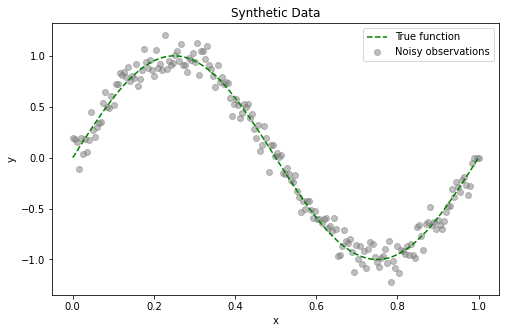

In [2]:
# Define the true function
def f(x):
    return torch.sin(2 * math.pi * x)

# Create a dense candidate pool over [0, 1]
x_all = torch.linspace(0, 1, 200)

# Generate noisy observations
noise_std = 0.1
y_all = f(x_all) + noise_std * torch.randn(x_all.size())

# Split off a test set (for evaluation) from the candidate pool
n_test = 50
indices = torch.randperm(x_all.size(0))
test_idx = indices[:n_test]
pool_idx = indices[n_test:]

x_test = x_all[test_idx]
y_test = y_all[test_idx]

# The remaining points form our candidate pool for active learning
x_pool = x_all[pool_idx]
y_pool = y_all[pool_idx]  # In a real setting, these labels are hidden and only obtained upon querying

# Plot the true function and the noisy observations
plt.figure(figsize=(8,5))
plt.plot(x_all.numpy(), f(x_all).numpy(), 'g--', label='True function')
plt.scatter(x_all.numpy(), y_all.numpy(), c='gray', alpha=0.5, label='Noisy observations')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Data')
plt.legend()
plt.show()

## 2. Defining the GP Model

We define an Exact GP model by subclassing `gpytorch.models.ExactGP`. In this example the model uses a constant mean and a scaled RBF kernel. This model will be retrained during the active learning loop as new data points are acquired.

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## 3. Active Learning Framework Overview

Our goal is to improve our GP model by iteratively adding the most informative data points from the candidate pool. In each iteration, we:

1. **Train** the GP on the current training set.
2. **Score** each candidate point by computing a score function. In this tutorial we use the **predictive variance** (uncertainty sampling).
3. **Select** the candidate with the highest score (i.e. the point with maximum predictive variance).
4. **Query** the label for this point (here we simulate it using our true function plus noise) and add it to the training set.

We will compare this active learning strategy with a baseline where new points are selected at random from the candidate pool.

In [4]:
def train_gp_model(train_x, train_y, training_iter=100):
    """
    Train an Exact GP model on the provided training data.
    Returns the trained model and likelihood.
    """
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
    
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    
    return model, likelihood

In [5]:
def compute_variance_scores(model, likelihood, candidates):
    """
    Compute the predictive variance for each candidate point.
    Returns a numpy array of variances.
    """
    model.eval()
    likelihood.eval()
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(candidates))
        variances = preds.variance
    
    return variances.numpy()

## 4. Active Learning Loop: Variance Sampling

Below we implement the active learning loop using the predictive variance as the score function. We start with a small initial training set, and in each iteration:

- Train a GP model on the current training set.
- Compute the predictive variance for all candidate points.
- Select the candidate with the highest variance and add it to the training set.
- Record the RMSE on the held-out test set for later comparison.

Let's run the active learning loop.

Iteration 1/30, Train size: 6, Test RMSE: 0.127
Iteration 2/30, Train size: 7, Test RMSE: 0.116
Iteration 3/30, Train size: 8, Test RMSE: 0.110
Iteration 4/30, Train size: 9, Test RMSE: 0.113
Iteration 5/30, Train size: 10, Test RMSE: 0.120
Iteration 6/30, Train size: 11, Test RMSE: 0.116
Iteration 7/30, Train size: 12, Test RMSE: 0.116
Iteration 8/30, Train size: 13, Test RMSE: 0.117
Iteration 9/30, Train size: 14, Test RMSE: 0.116
Iteration 10/30, Train size: 15, Test RMSE: 0.116
Iteration 11/30, Train size: 16, Test RMSE: 0.108
Iteration 12/30, Train size: 17, Test RMSE: 0.109
Iteration 13/30, Train size: 18, Test RMSE: 0.109
Iteration 14/30, Train size: 19, Test RMSE: 0.110
Iteration 15/30, Train size: 20, Test RMSE: 0.109
Iteration 16/30, Train size: 21, Test RMSE: 0.110
Iteration 17/30, Train size: 22, Test RMSE: 0.114
Iteration 18/30, Train size: 23, Test RMSE: 0.114
Iteration 19/30, Train size: 24, Test RMSE: 0.113
Iteration 20/30, Train size: 25, Test RMSE: 0.113
Iteration 21/

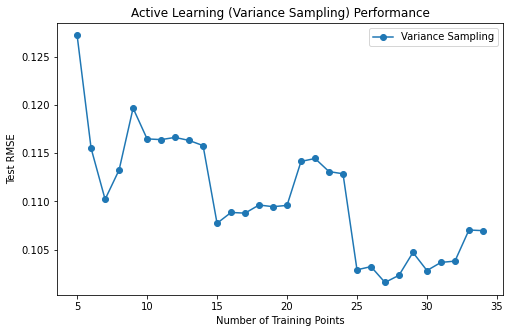

In [6]:
# Active Learning via Variance Sampling

# Initialize with a small random training set (e.g., 5 points)
n_initial = 5
initial_indices = torch.randperm(x_pool.size(0))[:n_initial]
train_x_active = x_pool[initial_indices].clone()
train_y_active = y_pool[initial_indices].clone()

# Remove the initial training points from the candidate pool
mask = torch.ones(x_pool.size(0), dtype=torch.bool)
mask[initial_indices] = False
x_pool_active = x_pool[mask]
y_pool_active = y_pool[mask]  

# Lists to store performance metrics
rmse_active = []
n_iterations = 30  # Number of active learning iterations

for it in range(n_iterations):
    # Train GP model on current training set
    model_active, likelihood_active = train_gp_model(train_x_active, train_y_active, training_iter=100)
    
    # Evaluate on the test set
    model_active.eval()
    likelihood_active.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds_test = likelihood_active(model_active(x_test))
        mean_test = preds_test.mean
    rmse = torch.sqrt(torch.mean((mean_test - y_test)**2)).item()
    rmse_active.append(rmse)
    
    # Compute variance scores on the remaining candidate pool
    variances = compute_variance_scores(model_active, likelihood_active, x_pool_active)
    
    # Select the candidate with maximum predictive variance
    best_idx = np.argmax(variances)
    
    # "Query" the label (simulate by using y_pool_active)
    new_x = x_pool_active[best_idx].unsqueeze(0)
    new_y = y_pool_active[best_idx].unsqueeze(0)
    
    # Add the new point to the training set
    train_x_active = torch.cat([train_x_active, new_x])
    train_y_active = torch.cat([train_y_active, new_y])
    
    # Remove the selected candidate from the pool
    mask = torch.ones(x_pool_active.size(0), dtype=torch.bool)
    mask[best_idx] = False
    x_pool_active = x_pool_active[mask]
    y_pool_active = y_pool_active[mask]
    
    print(f"Iteration {it+1}/{n_iterations}, Train size: {train_x_active.size(0)}, Test RMSE: {rmse:.3f}")

# Plot RMSE vs. Number of Training Points (Active Learning)
plt.figure(figsize=(8,5))
plt.plot(range(n_initial, n_initial + n_iterations), rmse_active, marker='o', label='Variance Sampling')
plt.xlabel('Number of Training Points')
plt.ylabel('Test RMSE')
plt.title('Active Learning (Variance Sampling) Performance')
plt.legend()
plt.show()

## 5. Active Learning Baseline: Random Sampling

For comparison, we now run a similar active learning loop where, instead of selecting the candidate with maximum variance, we randomly select a candidate point at each iteration. We record the test RMSE over iterations.

[Random] Iteration 1/30, Train size: 6, Test RMSE: 0.843
[Random] Iteration 2/30, Train size: 7, Test RMSE: 0.272
[Random] Iteration 3/30, Train size: 8, Test RMSE: 0.116
[Random] Iteration 4/30, Train size: 9, Test RMSE: 0.113
[Random] Iteration 5/30, Train size: 10, Test RMSE: 0.112
[Random] Iteration 6/30, Train size: 11, Test RMSE: 0.111
[Random] Iteration 7/30, Train size: 12, Test RMSE: 0.115
[Random] Iteration 8/30, Train size: 13, Test RMSE: 0.117
[Random] Iteration 9/30, Train size: 14, Test RMSE: 0.129
[Random] Iteration 10/30, Train size: 15, Test RMSE: 0.129
[Random] Iteration 11/30, Train size: 16, Test RMSE: 0.130
[Random] Iteration 12/30, Train size: 17, Test RMSE: 0.110
[Random] Iteration 13/30, Train size: 18, Test RMSE: 0.110
[Random] Iteration 14/30, Train size: 19, Test RMSE: 0.113
[Random] Iteration 15/30, Train size: 20, Test RMSE: 0.113
[Random] Iteration 16/30, Train size: 21, Test RMSE: 0.110
[Random] Iteration 17/30, Train size: 22, Test RMSE: 0.109
[Random] I

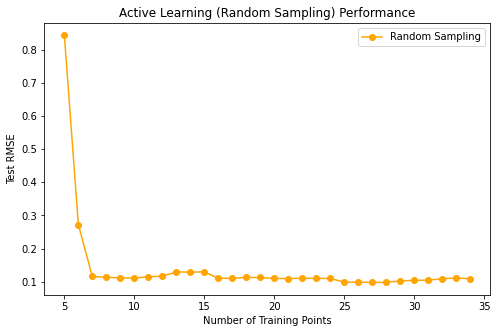

In [7]:
# Active Learning via Random Sampling (Baseline)

# Reinitialize training set (use the same initial points as before)
initial_indices = torch.randperm(x_pool.size(0))[:n_initial]
train_x_rand = x_pool[initial_indices].clone()
train_y_rand = y_pool[initial_indices].clone()

# Remove the initial training points from the candidate pool
mask = torch.ones(x_pool.size(0), dtype=torch.bool)
mask[initial_indices] = False
x_pool_rand = x_pool[mask]
y_pool_rand = y_pool[mask]

rmse_random = []

for it in range(n_iterations):
    # Train GP model on current training set
    model_rand, likelihood_rand = train_gp_model(train_x_rand, train_y_rand, training_iter=100)
    
    # Evaluate on the test set
    model_rand.eval()
    likelihood_rand.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds_test = likelihood_rand(model_rand(x_test))
        mean_test = preds_test.mean
    rmse = torch.sqrt(torch.mean((mean_test - y_test)**2)).item()
    rmse_random.append(rmse)
    
    # Randomly select a candidate from the pool
    idx = torch.randint(0, x_pool_rand.size(0), (1,)).item()
    
    new_x = x_pool_rand[idx].unsqueeze(0)
    new_y = y_pool_rand[idx].unsqueeze(0)
    
    # Add the new point to the training set
    train_x_rand = torch.cat([train_x_rand, new_x])
    train_y_rand = torch.cat([train_y_rand, new_y])
    
    # Remove the selected candidate from the pool
    mask = torch.ones(x_pool_rand.size(0), dtype=torch.bool)
    mask[idx] = False
    x_pool_rand = x_pool_rand[mask]
    y_pool_rand = y_pool_rand[mask]
    
    print(f"[Random] Iteration {it+1}/{n_iterations}, Train size: {train_x_rand.size(0)}, Test RMSE: {rmse:.3f}")

# Plot RMSE vs. Number of Training Points (Random Sampling)
plt.figure(figsize=(8,5))
plt.plot(range(n_initial, n_initial + n_iterations), rmse_random, marker='o', color='orange', label='Random Sampling')
plt.xlabel('Number of Training Points')
plt.ylabel('Test RMSE')
plt.title('Active Learning (Random Sampling) Performance')
plt.legend()
plt.show()

## 6. Results and Comparison

Below we compare the performance of the variance-based active learning strategy versus random sampling. In general, the active learning approach should yield a lower test RMSE as the training set grows.

You can further analyze and visualize the data as needed.

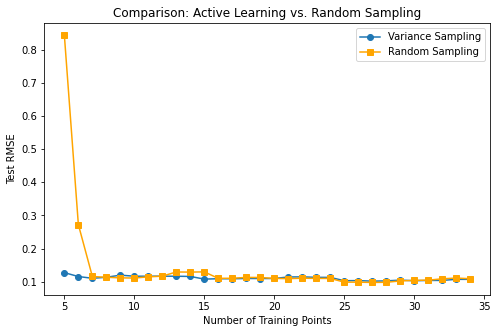

In [8]:
# (Optional) If you want to plot both curves on the same graph for comparison
plt.figure(figsize=(8,5))
plt.plot(range(n_initial, n_initial + n_iterations), rmse_active, marker='o', label='Variance Sampling')
plt.plot(range(n_initial, n_initial + n_iterations), rmse_random, marker='s', label='Random Sampling', color='orange')
plt.xlabel('Number of Training Points')
plt.ylabel('Test RMSE')
plt.title('Comparison: Active Learning vs. Random Sampling')
plt.legend()
plt.show()

## 7. Conclusion

In this notebook we:

- Generated synthetic data from a noisy sine function.
- Defined an Exact GP model in GPyTorch.
- Implemented an active learning loop that selects new training points based on the predictive variance.
- Compared the active learning strategy with a random sampling baseline using test RMSE as a metric.

This serves as a comprehensive introduction to Bayesian active learning with GPs in GPyTorch. Experiment further with other score functions (e.g., expected improvement, entropy-based criteria) and consider different settings (e.g., classification) for a deeper understanding.